In [29]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
experiments = {
    'baseline': '/home/shane/minerl/pdddqn/result/85a45807b34265153c1859459809b9d49691a674-2f630116-1ee07c14/',
    'k_16': '/home/shane/minerl/pdddqn/result/85a45807b34265153c1859459809b9d49691a674-653f3a8f-ea8043ef/'
}

In [31]:
rx_dict = {
    'statistics': re.compile(r"statistics:(?P<statistics>.*)\n"),
    'result': re.compile(r"outdir:result/.* (?P<result>step:(\d+) episode:(\d+) R:(.*))\n")
}
def _parse_line(line):
    for key, rx in rx_dict.items():
        match = rx.search(line)
        if match:
            #print(key)
            return key, match
    return None, None

In [55]:
# instead, join on episode. But, have to join the lines
train_losses = pd.DataFrame()
train_q_values = pd.DataFrame()
train_rewards = pd.DataFrame()

for name, path in experiments.items():
    statistics = []
    rewards = []
    
    # read the log file, parse the fields, create a statistics and rewards list
    with open(f"{path}log.txt", 'r') as f:
        for line in f:
            key, match = _parse_line(line)
            if key == 'statistics':
                # replace nan with 0
                stats = match.group('statistics').replace('nan', '0.0')
                # convert the list of tuples into a dict
                statistics.append(dict(eval(stats)))

            if key == 'result':
                result = match.group('result').replace('nan', '0.0').split()
                rewards.append(dict(map(lambda s : s.split(':'), result)))

        df = pd.DataFrame(rewards).apply(pd.to_numeric).set_index('episode')
        df = df.join(pd.DataFrame(statistics).set_index('cumulative_steps'), on='step')
        train_losses = pd.concat([train_losses, df['average_loss'].rename(name)], axis=1)
        train_q_values = pd.concat([train_q_values, df['average_q']], axis=1)
        train_rewards = pd.concat([train_rewards, df['R'].rename(name)], axis=1)

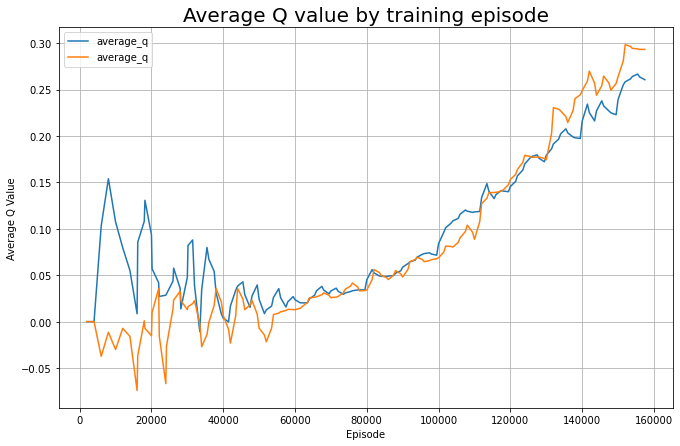

In [37]:
fig, ax = plt.subplots(figsize=(11,7))

# print(training_dfs[0].average_q[:10])
# print(training_dfs[1].average_q[:10])

# for df in training_dfs:
#     ax.plot(df.episode[:150], df.average_q[:150])

train_q_values[:150].interpolate().plot(ax=ax)

ax.set_title("Average Q value by training episode", fontsize=20)
ax.set_xlabel('Episode')
ax.set_ylabel('Average Q Value')
ax.grid()


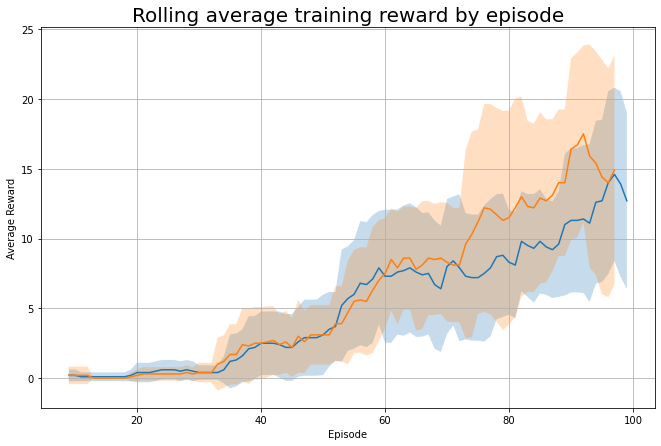

In [236]:
# maybe make this a dynamic window based on the size?
window = 10

fig, ax = plt.subplots(figsize=(11,7))

for df in training_dfs:
    mean = df['R'].rolling(window).mean()
    sigma = df['R'].rolling(window).std()
    ax.plot(df.episode[:100], mean[:100], label='Average reward')
    ax.fill_between(df.episode[:100], mean[:100]+sigma[:100], mean[:100]-sigma[:100], alpha=0.25)
    
ax.set_title("Rolling average training reward by episode", fontsize=20)
#ax.legend(loc='upper left')
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

In [213]:
df_eval = pd.read_csv(f"{filepath}scores.txt", sep="\t")
# prepend with e_ to signify evaluation
df_eval.columns = ['e_'+s for s in list(df_eval.columns)]

# might be better to use 2 different dataframes, one for each of training and evaluation?
df_joined = df_train.join(df_eval.set_index('e_steps'), on='step')

In [214]:
df_joined[:20]

,step,episode,R,average_q,average_loss,n_updates,rlen,e_episodes,e_elapsed,e_mean,e_median,e_stdev,e_max,e_min,e_average_q,e_average_loss,e_cumulative_steps,e_n_updates,e_rlen
0,2000,0,0.0,0.000000,0.000000,0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,2000,0,0.0,0.000000,0.000000,0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4000,1,1.0,0.000000,0.000000,0,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4000,1,1.0,0.000000,0.000000,0,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6000,2,0.0,0.103058,0.141552,248,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6000,2,0.0,-0.037295,0.136083,248,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8000,3,0.0,0.153867,0.112361,748,8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,8000,3,0.0,-0.011408,0.117088,748,8000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,4,0.0,0.107413,0.104383,1248,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10000,4,0.0,-0.030006,0.103491,1248,10000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [137]:
df_joined.e_mean[df_joined.e_mean.notna()]

7     1.000000
14    0.000000
22    0.000000
29    0.000000
37    4.000000
44    3.000000
52    4.000000
59    6.666667
Name: e_mean, dtype: float64

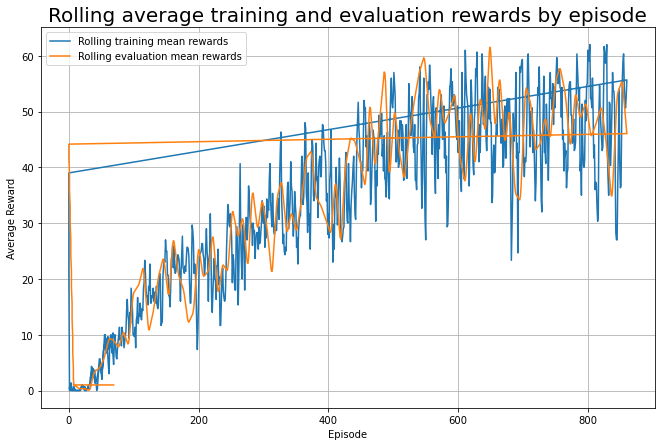

In [237]:
window = 3

train_mean = df_joined['R'].rolling(window).mean()
#one method, interpolate to skip over nans
eval_mean = df_joined['e_mean'].interpolate(method='linear').rolling(window).mean()

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_mean, label = 'Rolling training mean rewards')
ax.plot(df_joined.episode, eval_mean, label = 'Rolling evaluation mean rewards')
ax.set_title("Rolling average training and evaluation rewards by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Average Reward')
ax.grid()

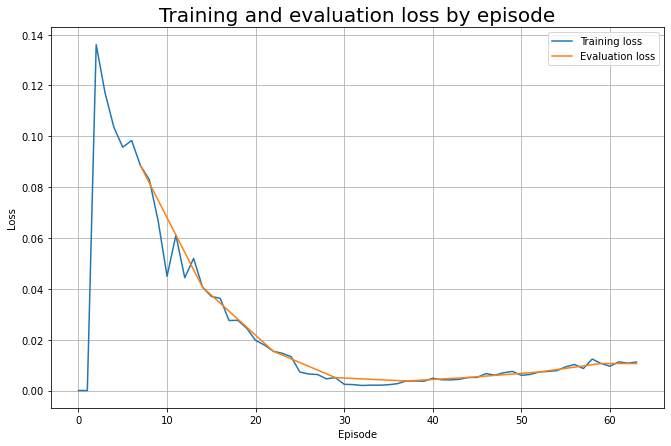

In [145]:
#method one, interpolation. I like this less
train_loss = df_joined['average_loss']
eval_loss = df_joined['e_average_loss'].interpolate(method='linear')

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_loss, label = 'Training loss')
ax.plot(df_joined.episode, eval_loss, label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.grid()

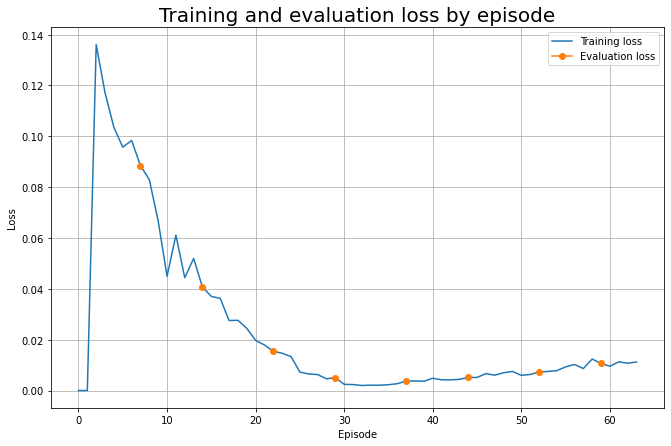

In [146]:
#method 2, plot with dots. I like this more

train_loss = df_joined['average_loss']
eval_loss = df_joined['e_average_loss']

fig, ax = plt.subplots(figsize=(11,7))
ax.plot(df_joined.episode, train_loss, label = 'Training loss')
ax.plot(df_joined.episode, eval_loss, 'o-', label = 'Evaluation loss')
ax.set_title("Training and evaluation loss by episode", fontsize=20)
ax.legend()
ax.set_xlabel('Episode')
ax.set_ylabel('Loss')
ax.grid()

In [147]:
df_scores

,e_steps,e_episodes,e_elapsed,e_mean,e_median,e_stdev,e_max,e_min,e_average_q,e_average_loss,e_cumulative_steps,e_n_updates,e_rlen
0,16000,8,1451.048231,1.0,1.0,0.000000,1.0,1.0,-0.074182,0.088454,16000,2748,16000
1,30000,15,2811.703656,0.0,0.0,0.000000,0.0,0.0,0.012949,0.040675,30000,6248,30000
2,46000,23,4315.972323,0.0,0.0,0.000000,0.0,0.0,0.012879,0.015430,46000,10248,46000
3,60000,30,5719.250610,0.0,0.0,0.000000,0.0,0.0,0.012816,0.005075,60000,13748,60000
4,76000,38,7276.524537,4.0,2.0,3.464102,8.0,2.0,0.041560,0.003753,76000,17748,76000
5,90000,45,10836.789388,3.0,4.0,2.645751,5.0,0.0,0.048025,0.005125,90000,21248,90000
6,106000,53,12383.926931,4.0,1.0,5.196152,10.0,1.0,0.090265,0.007276,106000,25248,106000
